In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk # imports the natural language toolkit
nltk.download('punkt')
nltk.download('stopwords')
import string
import plotly
from nltk.stem import PorterStemmer 
from collections import Counter
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.data import load
from nltk.stem import SnowballStemmer
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
import unicodedata
import re
from nltk.tag import StanfordPOSTagger
# Aquí obtenemos la lista de tokens en "tokens"
tagger="/home/ec2-user/stanford-tagger-4.0.0/models/spanish-ud.tagger"
jar="/home/ec2-user/stanford-tagger-4.0.0/stanford-postagger.jar"

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
%%time
df = pd.read_excel('Original_Data/Reporte Uraba2019_CAGMV1Est.xlsx')
df.head()

In [3]:
# df["RepairCode"].value_counts()
# null_rc = df[df["RepairCode"].isnull()]
# len(df["RepairCode"])
list(df.columns)


['CallID',
 'NumberOT',
 'TaskNumber',
 'Status',
 'SourceSystem',
 'ServiceType',
 'id',
 'Eng_Type',
 'RepairDate',
 'FinalRepairDate',
 'DuratioMin',
 'TaskType',
 'CompletionDate',
 'OpenDate',
 'EarlyStart',
 'DueDate',
 'DispatchDate',
 'TravelDate',
 'OnSiteDate',
 'Subsidiary',
 'Region',
 'District',
 'TreeServiceGroup',
 'ServiceGroup',
 'ServiceLine',
 'BusinessLine',
 'town',
 'Latitude',
 'Longitude',
 'Priority',
 'IncompleteReason',
 'CrewGeneralComments',
 'RepairCode',
 'W6Key',
 'IdEPM',
 'Empresa']

In [7]:
#priority_col_dict
#Mejorar los colores, función para cada RGB
df.Latitude = df.Latitude/1000000
df.Longitude = df.Longitude/1000000
df.Priority.unique()
priority_colors = ['#%02x%02x%02x' % (255, 0+(i*30), 0) for i in range(len(df.Priority.unique()))]
priority_colors = list(reversed(priority_colors))
priority_col_dict = dict(zip(df.Priority.unique(),priority_colors[-1::-1]))

#Center in Apartadó, Antioquia: (7.88299, -76.62587)
antioquia_map2 = folium.Map(location=[7.88299, -76.62587],
                        zoom_start=9,
                        tiles="OpenStreetMap")

for i in range(0,len(df)):
    marker = folium.CircleMarker(location=[ df["Latitude"][i], df["Longitude"][i] ],
                                 radius=2,
                                 color= priority_col_dict[df.Priority[i]],
                                 fill=True)
    marker.add_to(antioquia_map2)


antioquia_map2

In [ ]:
with open('./') as geo:
    geojson = json.loads(geo.read())
    



NAN
POSTE
SECUNDARIO
RED
SECUNDARIA
ACOMETIDAS
DOMICILIARIAS
BARRA
PRIMARIA
A
TRANSFORMADOR
TRANSFORMADOR
FUSIBLES
CASCADA


MANIOBRAS

LINEA
MUERTA
LINEA
VIVA

ALIMENTADOR
PRINCIPAL
SE
EJECUTAN
TRABAJOS
QUEDAN
ACTIVIDADES
PENDIENTES
CAPSULA
SERVICIO
PROVISIONAL
RECONECTADOR
ABIERTO
FALLA
ALIMENTADOR
PRINCIPAL
CIRCUITO
OBJETOS
LA
LINEA

ARBOL,RAMAS,COLAS
COMETA,OTROS

ALIMENTADOR
PRINCIPAL
REVISIÓN
CALIDAD
DEL
SERVICIO
QUEDA
PENDIENTE
LA
REPARACION
FALTA
HERRAMIENTAS
MATERIAL
ADECUADOS
FUSIBLE
AISLADERO
RAMAL


LINEA
SECUNDARIA
ROTA
CONECTOR
LA
RED
PRIMARIA


LINEA
PRIMARIA
CUBIERTA

ECOLOGICA



ARBOLES


Y
O
VIENTOS
PRIMARIOS
RETENIDA


NEUTRO
PRIMARIO


Y
O
HERRAJES
ACCESORIOS


POSTE
PRIMARIO


NO
SE
ENCONTRÓ
NADA
ANORMAL

VISITA
FALLIDA

SOLICITUD
PIN
DESBLOQUEO
MEDIDOR
PREPAGO
ACOMETIDAS
DOMICILIARIAS

ACOMETIDA
SECUNDARIA
TRABAJO
PROGRAMADO
CAMBIO
TECLADO
MEDIDOR
PREPAGO
CAMBIO
MEDIDOR
PREPAGO

SOLO
MEDIDOR

CABLE
SEÑAL
MEDIDOR
PREPAGO
FUSIBLE
A
TRANSFORMADOR
TRANSFORMADOR
FUSIB

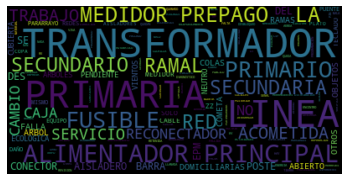

In [4]:
df["RepairCodeString"] = df["RepairCode"].apply(lambda x: str(x).upper())

text = " ".join(list(df["RepairCodeString"].unique()))
# text
# eliminate irrelevant words
irrelevant = ["RAMALES", " DE ", " EN ",  " POR ", " O " , " Y ", "/" ," PARA ", "(", ")", " - ", " -",  "- " ]

for st in irrelevant:
    text = text.replace(st," ")

# eliminate verbs
for wo in text.split(" "):
    word = str(wo).strip()
    
    if word.endswith("AR") or word.endswith("ER") or word.endswith("IR"):
        text = text.replace(word," ")
    else : print(word)
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# df["RepairCodeString"]

# Text analysis RepairCode


## First we extract a text and clean it

To do that, remove stopwords, NAN, RAMAL, RAMALES

In [30]:
es_stopwords = [str(x).upper() for x in stopwords.words("spanish")] 

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

es_stopwords_na = [remove_accents(x) for x in es_stopwords]
es_stopwords_na.extend(["NAN", "RAMAL", "RAMALES"])

def clean_text(text):
    # Remove non alphabetic charactets using pattern = r"[^\w]" seen in class
    
    pattern = r"[^\w]"
    ret = re.sub(pattern, " ", text)
    ret = remove_accents(ret)
    for bad in es_stopwords_na:
        
        to_replace = " " + bad + " " if bad != "NAN" else bad
        ret = ret.replace(to_replace, " ")
    return ret
    
# Create clean column    
df["RepairCodeStringClean"] = df["RepairCodeString"].apply(clean_text)
    
    

all_reviews_text = ' '.join(df["RepairCodeString"])
all_reviews_text = clean_text(all_reviews_text)

print(all_reviews_text)


# Get tokens
tokenized_words = nltk.word_tokenize(all_reviews_text)
# remove length smaller than 2
tokenized_words = [each.strip() for each in tokenized_words if len(each.lower()) > 2]


word_freq = Counter(tokenized_words)
ten_pct =round(len(word_freq)*0.1)

## Top 10%
word_freq.most_common(ten_pct)

## Similarly, bottom 10%
word_freq.most_common()[-ten_pct:-1]

df["RepairCodeStringClean"].apply(lambda x: np.nan if str(x).strip() == "" else x).dropna().head()

## First 5 repair codes n-grams
# first_5_revs = AllRCs[0:5]
# word_tokens = nltk.word_tokenize(''.join(first_5_revs))
# list(ngrams(word_tokens, 3)) #ngrams(word_tokens,n) gives the n-grams.

    CAMBIAR ASEGURAR POSTE SECUNDARIO CAMBIAR ASEGURAR RED SECUNDARIA ASEGUARAR REUBICAR ACOMETIDAS DOMICILIARIAS ASEGUARAR REUBICAR ACOMETIDAS DOMICILIARIAS CAMBIAR ASEGURAR POSTE SECUNDARIO CAMBIAR ASEGURAR RED SECUNDARIA REPARAR BARRA PRIMARIA TRANSFORMADOR   TRANSFORMADOR CAMBIAR FUSIBLES CASCADA       EJECUTAR MANIOBRAS  LINEA MUERTA  LINEA VIVA    ALIMENTADOR PRINCIPAL   EJECUTAN TRABAJOS QUEDAN ACTIVIDADES PENDIENTES CAMBIAR CAPSULA ACCIONAR BREAKER CONECTAR SERVICIO PROVISIONAL CERRAR RECONECTADOR ABIERTO FALLA   ALIMENTADOR PRINCIPAL INSPECCIONAR CIRCUITO EJECUTAR MANIOBRAS  LINEA MUERTA  LINEA VIVA    ALIMENTADOR PRINCIPAL RETIRAR OBJETOS LINEA  ARBOL RAMAS COLAS COMETA    ALIMENTADOR PRINCIPAL       REVISION CALIDAD SERVICIO               EJECUTAR MANIOBRAS  LINEA MUERTA  LINEA VIVA    ALIMENTADOR PRINCIPAL QUEDA PENDIENTE REPARACION FALTA HERRAMIENTAS MATERIAL ADECUADOS CAMBIAR INSTALAR FUSIBLE AISLADERO   REPARAR LINEA SECUNDARIA ROTA   CAMBIAR INSTALAR CONECTOR RED PRIMAR

2              CAMBIAR ASEGURAR POSTE SECUNDARIO
3                CAMBIAR ASEGURAR RED SECUNDARIA
4    ASEGUARAR REUBICAR ACOMETIDAS DOMICILIARIAS
5    ASEGUARAR REUBICAR ACOMETIDAS DOMICILIARIAS
6              CAMBIAR ASEGURAR POSTE SECUNDARIO
Name: RepairCodeStringClean, dtype: object

# N-Grams RepairCode

In [31]:
def top_k_ngrams(word_tokens,n,k):
    ## Getting them as n-grams
    n_gram_list = list(ngrams(word_tokens, n))
    ### Getting each n-gram as a separate string
    n_gram_strings = [' '.join(each) for each in n_gram_list]
    n_gram_counter = Counter(n_gram_strings)
    most_common_k = n_gram_counter.most_common(k)
    print(most_common_k)

In [32]:
top_k_ngrams(tokenized_words, 1, 10)

[('CAMBIAR', 271), ('TRANSFORMADOR', 174), ('FUSIBLE', 164), ('REPARAR', 136), ('MEDIDOR', 135), ('INSTALAR', 123), ('AISLADERO', 112), ('PREPAGO', 112), ('ASEGURAR', 88), ('SECUNDARIA', 74)]


In [33]:
top_k_ngrams(tokenized_words, 2, 10)

[('CAMBIAR INSTALAR', 117), ('MEDIDOR PREPAGO', 112), ('INSTALAR FUSIBLE', 86), ('FUSIBLE AISLADERO', 86), ('TRANSFORMADOR TRANSFORMADOR', 72), ('CAMBIAR FUSIBLE', 67), ('FUSIBLE TRANSFORMADOR', 65), ('REVISION CALIDAD', 50), ('CALIDAD SERVICIO', 50), ('ACOMETIDAS DOMICILIARIAS', 45)]


In [34]:
top_k_ngrams(tokenized_words, 3, 10)

[('CAMBIAR INSTALAR FUSIBLE', 86), ('INSTALAR FUSIBLE AISLADERO', 86), ('CAMBIAR FUSIBLE TRANSFORMADOR', 65), ('FUSIBLE TRANSFORMADOR TRANSFORMADOR', 65), ('REVISION CALIDAD SERVICIO', 50), ('SOLICITUD PIN DESBLOQUEO', 39), ('PIN DESBLOQUEO MEDIDOR', 39), ('DESBLOQUEO MEDIDOR PREPAGO', 39), ('ASEGURAR REPARAR ACOMETIDAS', 36), ('REPARAR ACOMETIDAS DOMICILIARIAS', 36)]


In [35]:
top_k_ngrams(tokenized_words, 4, 10)

[('CAMBIAR INSTALAR FUSIBLE AISLADERO', 86), ('CAMBIAR FUSIBLE TRANSFORMADOR TRANSFORMADOR', 65), ('SOLICITUD PIN DESBLOQUEO MEDIDOR', 39), ('PIN DESBLOQUEO MEDIDOR PREPAGO', 39), ('ASEGURAR REPARAR ACOMETIDAS DOMICILIARIAS', 36), ('CAMBIO TECLADO MEDIDOR PREPAGO', 33), ('REPARAR LINEA SECUNDARIA ROTA', 31), ('INSTALAR FUSIBLE AISLADERO CAMBIAR', 27), ('FUSIBLE TRANSFORMADOR TRANSFORMADOR CAMBIAR', 26), ('QUEDA PENDIENTE REPARACION FALTA', 23)]


In [22]:
# nltk.pos_tag(tokenized_words)
# import spaghetti as sgt

# sent1 = 'Mi colega me ayuda a programar cosas .'.split()
# sent2 = 'Está embarazada .'.split()
# test_sents = [sent1, sent2]

# # Default Spaghetti tagger.
# print (sgt.pos_tag(test_sent))

# # Tag multiple sentences.
# print (sgt.pos_tag_sents(test_sents))

# spa_tagger = sgt.CESSTagger()
# # POS tagger trained on unigrams of CESS corpus.
# spa_unigram_tagger = spa_tagger.uni
# print (spa_unigram_tagger.tag(sent1))
# # POS tagger traned on bigrams of CESS corpus.
# spa_bigram_tagger = spa_tagger.bi
# print (spa_bigram_tagger.tag(sent2))
# print (spa_bigram_tagger.tag_sents(test_sents))

ModuleNotFoundError: No module named 'spaghetti'

In [27]:
# # Now lets PoD tag everything
# etiquetador=StanfordPOSTagger(tagger,jar)
# etiquetas=etiquetador.tag(tokenized_words)
# etiquetas

Loading default properties from tagger /home/ec2-user/stanford-tagger-4.0.0/models/spanish-ud.tagger
Loading POS tagger from /home/ec2-user/stanford-tagger-4.0.0/models/spanish-ud.tagger ... done [1.4 sec].
OpenJDK 64-Bit Server VM warning: INFO: os::commit_memory(0x00000000e037b000, 196608, 0) failed; error='Cannot allocate memory' (errno=12)



OSError: Java command failed : ['/usr/lib/jvm/jre/bin/java', '-mx1000m', '-cp', '/home/ec2-user/stanford-tagger-4.0.0/stanford-postagger.jar', 'edu.stanford.nlp.tagger.maxent.MaxentTagger', '-model', '/home/ec2-user/stanford-tagger-4.0.0/models/spanish-ud.tagger', '-textFile', '/tmp/tmpn83s17n_', '-tokenize', 'false', '-outputFormatOptions', 'keepEmptySentences', '-encoding', 'utf8']